In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from scipy import integrate
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

In [55]:
abortion= pd.read_csv("abortion.csv")
abortion= abortion[['country', 'region','anc_4plus', 'upreg', 'upreg_no_cp', 'upreg_abortion_no_cp', 'curr_costs_cp_percap', 'curr_costs_prnc_percap', 'curr_abortion_pac_costs_percap', 'rate_matdeaths', 'sti_nocare', 'inneed_married', 'inneed_formerlymar', 'inneed_nevermar', 'wra']]
dict={'Latin America & the Caribbean':0, 'Asia':1, 'Europe':2,  'Africa':3, 'Oceania':4}
abortion['region']=[dict[x] for x in abortion['region']]

In [379]:
abortion['inneed']=(abortion['inneed_formerlymar']+abortion['inneed_nevermar']+abortion['inneed_married'])/abortion['wra']
abortion['upreg_std']=abortion['upreg_no_cp']/abortion['upreg']
abortion['upreg_abortion_std']=abortion['upreg_abortion_no_cp']/abortion['upreg']
abortion=abortion.dropna(subset=['upreg'])
variables=abortion.drop(columns=['country', 'region', 'upreg', 'wra'])
categories=abortion['region']

from sklearn.preprocessing import StandardScaler

# Assuming df is your pandas DataFrame with the features

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
variables = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)


In [393]:
len(variables)

108

In [345]:
in_dim = 14
out_dim = 5 # there are 10 distinct digits (classes)
hidden_dim = 64
n_epochs = 20 
batch_size = 1
learning_rate = 1e-3 

#PREPARING
x_train, x_test, y_train, y_test = train_test_split(variables,
                                                    categories, 
                                                    test_size=0.25)
#TRAINING#######################
x_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#TESTING#########################
x_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_tensor = torch.tensor(y_test.values, dtype=torch.long)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader_test = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[[4 0 0 0 0]
 [0 5 0 0 1]
 [0 1 1 0 0]
 [0 0 0 9 0]
 [0 0 0 1 0]]
Accuracy = 0.864
[[5 0 0 1 0]
 [0 3 1 0 0]
 [1 1 2 0 0]
 [1 0 0 6 0]
 [0 0 0 0 1]]
Accuracy = 0.773
[[6 0 0 0 0]
 [0 3 0 0 1]
 [0 0 3 0 0]
 [0 0 0 7 0]
 [0 1 0 0 1]]
Accuracy = 0.909
[[4 0 0 0 0]
 [0 5 0 0 1]
 [0 0 1 0 0]
 [1 0 0 8 0]
 [1 0 0 0 1]]
Accuracy = 0.864
[[5 0 0 0 0]
 [0 6 0 1 0]
 [0 1 1 0 0]
 [0 0 0 7 0]
 [0 1 0 0 0]]
Accuracy = 0.864
0.8545454545454545


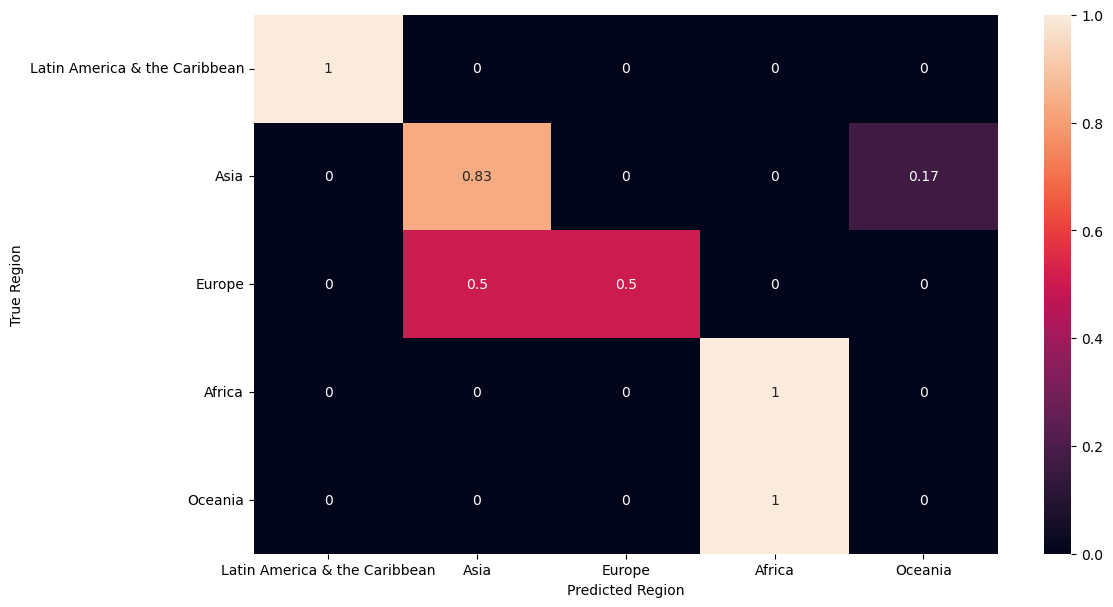

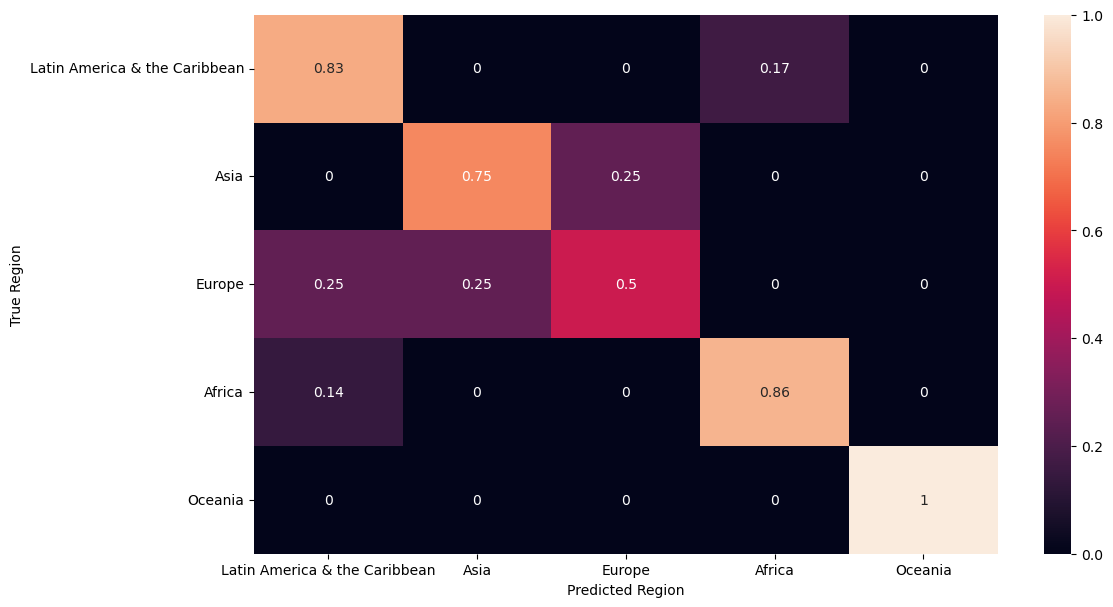

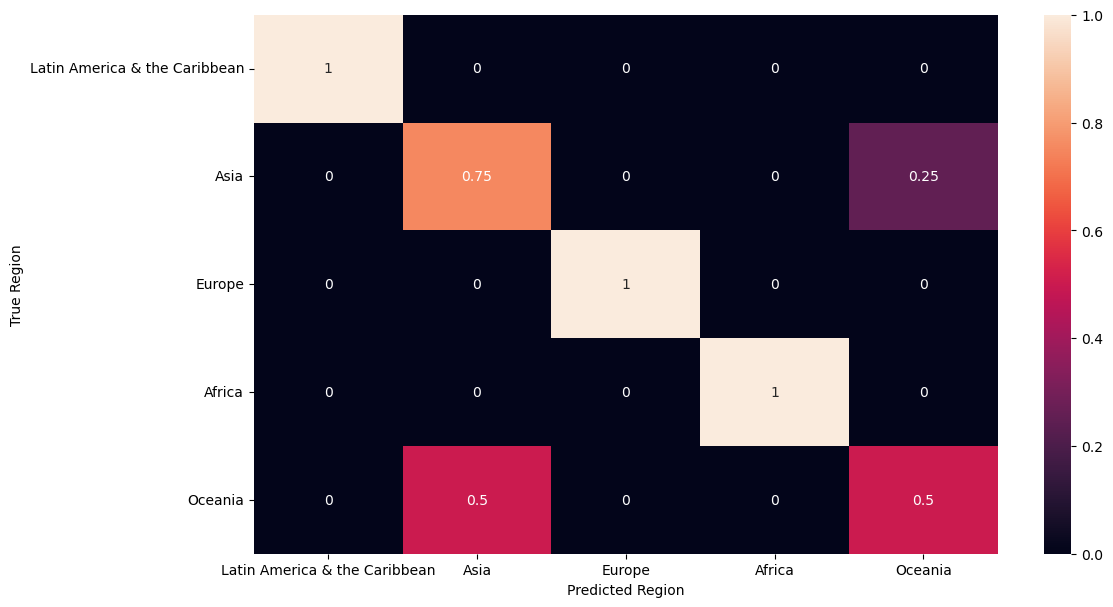

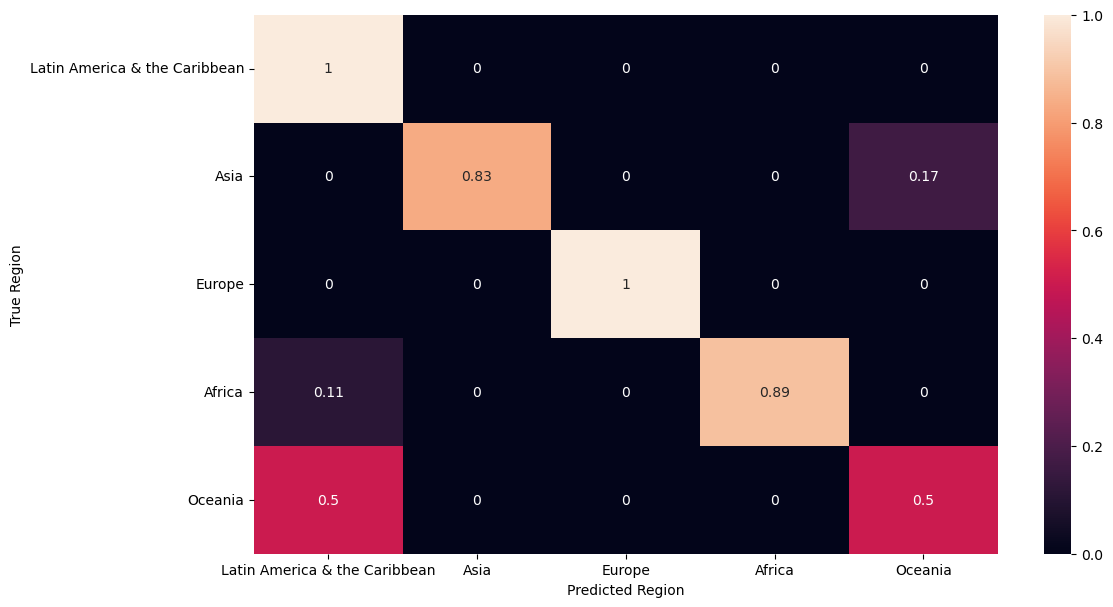

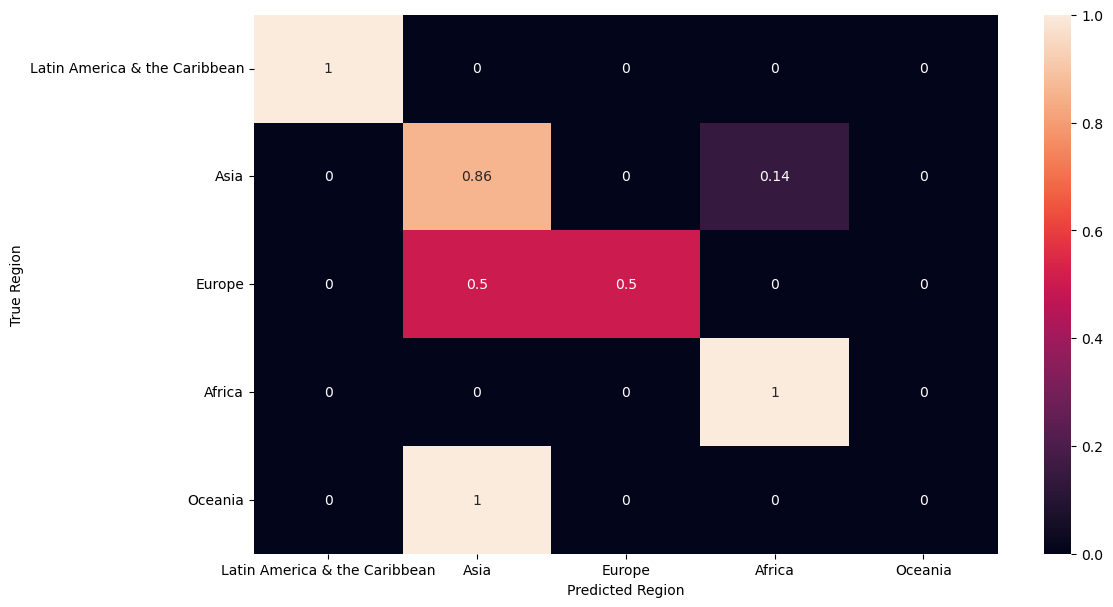

In [408]:
accuracies2=[]
for j in range(5):    
    in_dim = 14
    out_dim = 5 # there are 10 distinct digits (classes)
    hidden_dim = 64
    hidden_dim2=32
    n_epochs = 40
    batch_size = 8
    learning_rate = 1e-3

    #PREPARING
    x_train, x_test, y_train, y_test = train_test_split(variables,
                                                        categories, 
                                                        test_size=0.2)
    #TRAINING#######################
    x_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values, dtype=torch.long)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #TESTING#########################
    x_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_test.values, dtype=torch.long)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader_test = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Defining Model
    #Linear NN attempt
    ##########################################
    # Specify the model class (model design) #
    ##########################################

    class Multiclass(nn.Module): 
        
        def __init__(self, in_dim, hidden_dim, out_dim):
            super().__init__() # inherited constructor
            self.layer_1 = nn.Linear(in_dim, hidden_dim)
            self.elu = nn.ELU() # Rectifier Linear Unit 
                                # activation function 
            self.layer_2 = nn.Linear(hidden_dim, out_dim)

        
        def forward(self, x): 
            output = self.layer_1(x)
            output = self.elu(output)
            output = self.layer_2(output)

            # No final activation function: 
            #    the loss function will expect 
            #    the unnormalized numbers as input
            return output
        
    ###################################
    # Create an instance of the model #
    ###################################

    model = Multiclass(in_dim, hidden_dim, out_dim)


    ######################################
    # Define loss function and optimizer # 
    ######################################
    loss_fun = nn.CrossEntropyLoss() # A loss function that expects 
                                    # unnormalized input  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)





    losses = [] 
    for epoch in range(n_epochs): 
        for k, (imgs, lbls) in enumerate(dataloader_train): 
            
            # Forward pass and loss
            #imgs = imgs.view(-1, 28*28) # each row will contain one 
                                        # 'flattened' image from batch
            network_outputs = model(imgs) # one prediction per image 
                                        # from the batch
            loss = loss_fun(network_outputs, lbls) # compare predictions 
                                                # and labels
            
            # Backward pass and parameter adjustment
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # so as not to accumulate grads 
                                # between batches
            
            # Indicate progress
            #if k%200 == 0: 
                #print('Epoch %d, batch %d: loss = %.3f'%(epoch, k, loss.item()))
            losses.append(loss)

    if i <5:       
        win = 10

        losses_values = [x.detach().numpy() for x in losses] # remove the computational graph from each tensor
        losses_values = np.convolve(losses_values, np.ones(win), 'valid') / win # rolling window average
        iters = np.array(range(len(losses_values)))
        losses_values = losses_values[::win]
        iters = iters[::win] 

        plt.figure()
        plt.plot(iters, losses_values) 
        plt.xlabel('Iterations')
        plt.ylabel('Loss');            
    else:
        pass
    #####################Confusion Matrix###################
    from sklearn.metrics import confusion_matrix
    import seaborn as sn


    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in dataloader_test:
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('Latin America & the Caribbean', 'Asia', 'Europe',  'Africa', 'Oceania')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel("Predicted Region")
    plt.ylabel("True Region")
    plt.savefig('output.png')
    #############################################################
    accuracy = 0 
    with torch.no_grad(): 
        for imgs, lbls in dataloader_test:
            #imgs = imgs.view(-1, 28*28)
            network_outputs = model(imgs)
            _, y_hats = torch.max(network_outputs, dim=1) # pick class 
                                                        # with maxinal 
                                                        # likelihood
            accuracy += (y_hats == lbls).sum().item()

    accuracy = accuracy / len(dataloader_test.dataset)    
    mystr = ' (yay!)' if accuracy>=0.95 else '' 
    #print('Accuracy = %.3f'%accuracy, mystr)
    print('Accuracy = %.3f'%accuracy)
    accuracies2.append(accuracy)
print(np.mean(accuracies2))



In [412]:
np.std(accuracies3)

0.0628194316412966

In [395]:
print(dataloader_test)

This model uses a linear neural network to predict a country's region based off of statistics relating to women and abortion. All 14 original features we selected were standardized and inputted to the network. When designing the model, we believed the data was most suited for a simple linear model rather than a convolutional network because of the number of features we have (14) and the number of region categories (5). Additionally since we were working with a set of features rather than image data, a linear NN was a better choice than a CNN. Some of the hyperparameters are used specified below.
    in_dim = 14
    out_dim = 5 
    hidden_dim = 64
    hidden_dim2=32
    n_epochs = 40
    batch_size = 8
    learning_rate = 1e-3

The model consists of one hidden layer and uses an Exponential Linear Unit (ELU) activation function. After experimenting with different hyperparameters and network structres, including batch size learning rate and different activation functions, we found this model to preform the best. After splitting the training and testing data with an 80:20 ratio, training the network and validating using the test data, we find an 90.9% accuracy. The confusion matrix describing the predicted labels is shown below. As we see through the confusion matrix, the model has the msot difficulty predicting countries in Oceania. We foresaw this difficulty due to the small number of countries in this region. We can also see through the confusion matrix that Asian countries are also confused with Oceania. Some of these limitations we believe to be primarily due to the scarcity of complete data for this region. 

The network was run multiple times, varying splits of trianing and testing data. When the network was run 20 times, the average accuraies over these runs is 87.7%. The standard deviations of these accuracies is 6.2%. This signifies that the percent accuracy is variable based on the trianing and test split, however the standard deviation is relatively agreeable within the social sciences, meaning there is not a detimental variation within the accuracies. 